# Edge Detection based Segmentation

```
Objective:
```
The idea is to take the image of a room and understand/classify the various objects present in it. The objects are then masked with a colour

```
Approach:
```
K Means based clustering is used to perform the segmentation since it's an Unsupervised approach and doesn't need a pre-trained model. This approach makes the solution work with different domains

# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.pyplot import imshow
import numpy as np
import numpy.ma as ma
from sklearn.cluster import KMeans
from PIL import Image
from skimage.color import rgb2hsv
import os
import cv2 as cv
import random

# Constants

In [2]:
DIR_SKT = './sketches/'
DIR_INP = './room_scenes/'
DIR_OUT = './input/'
DIR_TRN = DIR_OUT+'train/'
DIR_TST = DIR_OUT+'test/'
S_RATIO = 0.85
NO_CLUS = 5

# RGB Values for various classes
cls = list()
for color in clr.BASE_COLORS.values():
    cls.append(list(round(i*255) for i in color))

# RGB value for a Masked Pixel
msk = [0,0,0] #Fully transparent

# Functions

In [3]:
# Function to delete all files in the output folder
def deleteFiles(fpath):
    """
    Delete Files in the output directory
    """
    files = os.listdir(fpath)
    for f in files:
        os.remove(fpath+f)

# Execute KMeans clustering on the input
def doClustering(inp):
    """
    Perform KMeans clustering on the input
    """
    vec = np.uint8(inp.reshape((-1,3)))
    kmn = KMeans(random_state=42, init='random', n_clusters=NO_CLUS)
    return kmn.fit_predict(vec)

# Function to perform Segmentation on an Image
def doSeg4Image(inp, doMasking=False):
    """
    Perform Segmentation on an Image Array (256,256,3)
    """
    lbl = doClustering(inp)
    out = list()
    rng = (NO_CLUS+1) if doMasking==True else 1
    for iter in range(rng):
        cpy = np.zeros((lbl.shape[0],3), dtype=np.uint8)
        for i, j in enumerate(lbl):
            cpy[i] = cls[j] if iter==0 else cls[0] if (iter-1)==j else cls[j]
        out.append(np.reshape(cpy, (256,256,3)))
    return out

# Function to detect edges of an image
def doEdgeDetection(inp):
    img = cv.cvtColor(inp, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(img,100,200,7)
    edges = 255 - edges
    col = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)
    lst = list()
    lst.append(np.reshape(col, (256,256,3)))
    return lst
    return cv.merge([edges, edges, edges])
    return edges

#Function to do Segmentation for files in a Folder
def doSegmentation(inputFolder, trainPath, testPath, ratio=S_RATIO):
    """
    Perform Segmentation on all Files in a Directory
    """
    files = os.listdir(inputFolder)
    threshold = round(number=len(files)*ratio)
    for idx, fil in enumerate(files):
        f = trainPath if idx<=threshold else testPath
        im0 = Image.open(fp=inputFolder+fil)
        im1 = im0.resize(size=(256,256))
        inp = np.array(im1)
        out = doEdgeDetection(inp)
        for idx, val in enumerate(out):
            fin = np.concatenate((inp,val), axis=1)
            img = Image.fromarray(fin)
            img.save(fp=f+str(idx)+fil)

In [4]:
im0 = Image.open(fp='/home/cds/poc/20220927_KMeansPix2PixGAN/room_scenes/ikea-a-fresh-way-to-keep-your-clothes-tidy__1364315963128-s4.jpg')
im1 = im0.resize(size=(256,256))
inp = np.array(im1)
out = doEdgeDetection(inp)
#abc = cv.merge([out, out, out])

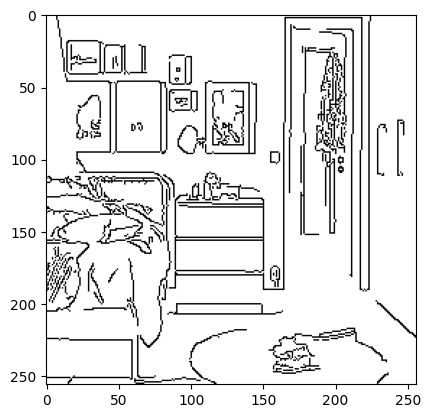

In [5]:
plt.imshow(out[0])

# Core Logic

In [6]:
# Delete all the files in the output folders
os.makedirs(DIR_TRN, exist_ok=True)
os.makedirs(DIR_TST, exist_ok=True)
deleteFiles(DIR_TRN)
deleteFiles(DIR_TST)
doSegmentation(DIR_INP, DIR_TRN, DIR_TST)
doSegmentation(DIR_SKT, DIR_TRN, DIR_TST, -1)